In [377]:
# Relevant imports
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, StackedNN, ResNet, count_parameters
from utils import RAD_sampler, sample_collocation_points
from NavierStokesData import NavierStokesData

In [378]:
sample_sizes = [100, 500, 1000, 2000]
noise_levels = [0.0, 0.1]

In [379]:
# Data points
data = NavierStokesData(samplesize=2000, noise_level=0.01)
Zd = data.Zd
Ud = data.Ud

# # Get index of datapoints on the boundary
# idx = (data.Zd_full[:, 0] == 1)
# Zd = data.Zd_full[idx]
# Ud = data.Ud_full[idx]

# # # Get index of initial datapoints
# # idx = (data.Zd_full[:, 2] == 0)
# # Zd = data.Zd_full[idx]
# # Ud = data.Ud_full[idx]

In [380]:
# Collocation points
N_coll = 10000
Xc = sample_collocation_points(N_coll, 3, [1, -2, 0], [8, 2, 20], method='sobol')

In [381]:
def compute_grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]

class NavierStokes(torch.nn.Module):
    def __init__(self, lambda1, lambda2):
        super(NavierStokes, self).__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2


    def forward(self, Z, U):

        psi = U[:, 0:1]
        p = U[:, 1:2]

        U_z = compute_grad(psi, Z)

        psi_x = U_z[:, 0:1]
        psi_y = U_z[:, 1:2]

        u = psi_y
        v = -psi_x

        u_z = compute_grad(u, Z)
        u_x = u_z[:, 0:1]
        u_y = u_z[:, 1:2]
        u_t = u_z[:, 2:3]

        v_z = compute_grad(v, Z)
        v_x = v_z[:, 0:1]
        v_y = v_z[:, 1:2]
        v_t = v_z[:, 2:3]

        p_z = compute_grad(p, Z)
        p_x = p_z[:, 0:1]
        p_y = p_z[:, 1:2]

        u_xx = compute_grad(u_x, Z)[:, 0:1]
        u_yy = compute_grad(u_y, Z)[:, 1:2]

        v_xx = compute_grad(v_x, Z)[:, 0:1]
        v_yy = compute_grad(v_y, Z)[:, 1:2]

        f = u_t + self.lambda1 * (u * u_x + v * u_y) + p_x # - self.lambda2 * (u_xx + u_yy)
        g = v_t + self.lambda1 * (u * v_x + v * v_y) + p_y # - self.lambda2 * (v_xx + v_yy)

        return torch.cat([f, g], dim=1)

lambda1 = 1.0
lambda2 = 0.01

N = NavierStokes(lambda1, lambda2)

In [ ]:
class NavierStokesUPINN(UPINN):
    
    def score(self):

        Xtest = data.Zd_full.requires_grad_(True)

        U_pred = self.u(Xtest)
        psi_z = compute_grad(U_pred[:, 0], Xtest)
        psi_y = psi_z[:, 1:2]
        psi_x = psi_z[:, 0:1]

        data_pred = torch.cat([psi_y, -psi_x], dim=1)
        data_true = data.Ud_full[:, 0:2]

        L2_rel_error = torch.sqrt(torch.mean((data_pred - data_true)**2) / torch.mean(data_true**2))

        print(torch.nn.MSELoss()(data_pred, data_true).item())

        return L2_rel_error.item()
    

    def score_residual(self):
        
        # Expected residual
        x = torch.linspace(1, 8, 30)
        y = torch.linspace(-2, 2, 30)
        t = torch.linspace(0, 20, 30)

        Z = torch.cartesian_prod(x, y, t).requires_grad_(True)

        U_pred = self.u(Z)
        psi_z = compute_grad(U_pred[:, 0], Z)
        psi_y = psi_z[:, 1:2]
        psi_x = psi_z[:, 0:1]

        u_pred = psi_y
        v_pred = -psi_x

        u_z = compute_grad(u_pred, Z)
        u_x = u_z[:, 0:1]
        u_y = u_z[:, 1:2]

        v_z = compute_grad(v_pred, Z)
        v_x = v_z[:, 0:1]
        v_y = v_z[:, 1:2]

        u_xx = compute_grad(u_x, Z)[:, 0:1]
        u_yy = compute_grad(u_y, Z)[:, 1:2]

        v_xx = compute_grad(v_x, Z)[:, 0:1]
        v_yy = compute_grad(v_y, Z)[:, 1:2]

        res_exp_f = - lambda2 * (u_xx + u_yy)
        res_exp_g = - lambda2 * (v_xx + v_yy)
        res_exp = torch.cat([res_exp_f.reshape(-1,1), res_exp_g.reshape(-1,1)], dim=1)

        # Predicted residual
        res_pred = self.F(self.F_input(Z, U_pred))

        # Residual MSE
        # residual_loss = torch.mean((res_exp - res_pred)**2)
        print(torch.mean((res_exp - res_pred)**2).item())
        print(torch.corrcoef(torch.cat([res_exp[:, 0], res_pred[:, 0]])).item())
        print(torch.corrcoef(torch.cat([res_exp[:, 1], res_pred[:, 1]])).item())

        # temp = data.get_quantities(self)

        # f_res_true = temp["f_res_true"]
        # g_res_true = temp["g_res_true"]

        # f_res_exp = temp["f_res_exp"]
        # g_res_exp = temp["g_res_exp"]

        # f_res_pred = temp["f_res_pred"]
        # g_res_pred = temp["g_res_pred"]

        # print('True:', np.sqrt((np.mean((f_res_true - f_res_pred)**2) + np.mean((g_res_true - g_res_pred)**2)) / (np.mean(f_res_true**2) + np.mean(g_res_true**2)))) 

        L2_rel_error = torch.sqrt(torch.mean((res_exp - res_pred)**2) / torch.mean(res_exp**2))
        return L2_rel_error.item()


    def data_loss(self):

        if self.data_points is not None:
            
            self.data_points[0].requires_grad_(True)

            Ud = self.u(self.data_points[0])

            psi_z = compute_grad(Ud[:, 0], self.data_points[0])
            psi_y = psi_z[:, 1:2]
            psi_x = psi_z[:, 0:1]

            # data_pred = torch.cat([psi_y, -psi_x], dim=1)
            # data_loss = torch.mean((data_pred - self.data_points[1][:, 0:2])**2)

            data_pred = torch.cat([psi_y, -psi_x, Ud[:, 1:2]], dim=1)
            data_loss = torch.mean((data_pred - self.data_points[1][:, 0:3])**2)

            # self.log.setdefault("lambda1", []).append(lambda1.item())
            # self.log.setdefault("lambda2", []).append(lambda2.item())

        else: data_loss = torch.tensor(0.0)

        return data_loss
    
    def F_input(self, Z, U):
        
        psi = U[:, 0:1]
        
        U_z = compute_grad(psi, Z)

        psi_x = U_z[:, 0:1]
        psi_y = U_z[:, 1:2]

        u = psi_y
        v = -psi_x

        if not self.inductive_bias:
            return torch.cat([Z, u, v], dim=1)
        else:

            u_z = compute_grad(u, Z)
            u_x = u_z[:, 0:1]
            u_y = u_z[:, 1:2]

            v_z = compute_grad(v, Z)
            v_x = v_z[:, 0:1]
            v_y = v_z[:, 1:2]

            u_xx = compute_grad(u_x, Z)[:, 0:1]
            u_yy = compute_grad(u_y, Z)[:, 1:2]

            v_xx = compute_grad(v_x, Z)[:, 0:1]
            v_yy = compute_grad(v_y, Z)[:, 1:2]

            u_xy = compute_grad(u_x, Z)[:, 1:2]
            v_xy = compute_grad(v_x, Z)[:, 1:2]

            return torch.cat([u, v, u_x, u_y, v_x, v_y, u_xy, v_xy, u_xx, u_yy, v_xx, v_yy], dim=1)



    # def refine_collocation_points(self):
    #     N = 10*N_coll
    #     D = N_coll
    #     k = 0.5
    #     c = 0.1

    #     device = self.device
    #     Xc = sample_collocation_points(N, 3, lb=[1, -2, 0], ub=[8, 2, 20], method='sobol').requires_grad_(True).to(device)

    #     self.to(device)

    #     # Compute the residual
    #     U = self.u(Xc)
    #     residual = torch.sum(torch.abs(self.F(self.F_input(Xc, U)) + self.N(Xc, U)), dim=1)

    #     self.to('cpu')

    #     self.collocation_points = RAD_sampler(Xc, residual, D, k, c) # RAD
    


In [383]:
hidden_u = [64] * 8

u = FNN(
    dims=[3, *hidden_u, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

hidden_F = [64] * 8

F = FNN(
    dims=[5, *hidden_F, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

In [384]:
u = ResNet(
    input_dim=3, hidden_dim=40, output_dim=2, num_blocks=4, block_size=2,
)

F = ResNet(
    input_dim=5, hidden_dim=40, output_dim=2, num_blocks=4, block_size=2,
)

In [385]:
model = NavierStokesUPINN(u, N, F, data_points=(Zd, Ud), collocation_points=Xc)
model.inductive_bias = False
# name = 'ns-upinn-with-pressuredata-FNN64-softadapt005-10000-collocation-2000-data-RAD'
name = 'ns-upinn-with-pressuredata-resnet40-softadapt02-lw-2000'
model.load(name, 'models')

[Info]: Initializing UPINN model


In [386]:
model.score()

0.00012345275899861008


0.01660352386534214

In [ ]:
model.score_residual()

0.00020498517551459372
1.0
1.0


1.0500385761260986

In [372]:
# u = ResNet(
#     input_dim=3, hidden_dim=40, output_dim=2, num_blocks=4, block_size=2,
# )

# F = ResNet(
#     input_dim=5, hidden_dim=40, output_dim=2, num_blocks=4, block_size=2,
# )

In [373]:
# u1 = FNN(
#     dims=[3, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# u2 = FNN(
#     dims=[3, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# u = StackedNN([u1, u2])

# F1 = FNN(
#     dims=[5, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# F2 = FNN(
#     dims=[5, *hidden, 1],
#     hidden_act=torch.nn.Tanh(),
#     output_act=torch.nn.Identity(),
# )

# F = StackedNN([F1, F2])

In [374]:
# hidden = [4] * 4

# u = KAN([3, *hidden, 2])
# F = KAN([5, *hidden, 2])

In [375]:
model = NavierStokesUPINN(u, N, F, data_points=(Zd, Ud), collocation_points=Xc)
model.inductive_bias = False

[Info]: Initializing UPINN model


In [376]:
model.score_residual()

0.00020498517551459372
1.0
1.0


0.9560412168502808

In [29]:
model.softadapt_kwargs = dict(beta=0.05, loss_weigthed=False)

In [ ]:
name = 'ns-upinn-with-pressuredata-FNN64-softadapt005-10000-collocation-2000-data-RAD'
# model.load(name, 'models')

In [31]:
adam = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(adam, step_size=500, gamma=0.8)
lbfgs = torch.optim.LBFGS(model.parameters(), lr=1e-1)

model.scheduler = scheduler

In [139]:
# for i in range(15):
#     model.optimizer = adam
#     model.train_loop(1000)
#     model.optimizer = lbfgs
#     model.train_loop(50)
#     model.refine_collocation_points(method='RAD', lb=[1, -2, 0], ub=[8, 2, 20], N_new=N_coll, N_candidates=10*N_coll)
#     if not torch.isnan(model.get_loss()[0]).item():
#         model.save(name, 'models', overwrite=True)
#         np.save('loss/loss_'+name, model.log['loss'])

# if not torch.isnan(model.get_loss()[0]).item():
#     model.optimizer = adam
#     model.train_loop(20000)
#     model.save(name, 'models', overwrite=True)
#     np.save('loss/loss_'+name, model.log['loss'])

# model.optimizer = lbfgs
# model.train_loop(100)
# if not torch.isnan(model.get_loss()[0]).item():
#     model.save(name, 'models', overwrite=True)
#     np.save('loss/loss_'+name, model.log['loss'])

In [474]:
# model.save('ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-500', 'models', overwrite=True)
# np.save('loss/loss_ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-500', model.log['loss'])

In [475]:
# model.load('ns-upinn-with-pressuredata-plain-softadapt02-lw-RAD-alt-5000', 'models')

In [476]:
# plt.figure(figsize=(8, 3))
# plt.plot(model.log['loss'], 'b', label='Loss')
# plt.plot(model.log['data_loss'], 'r', label='Data loss')
# plt.plot(model.log['pde_loss'], 'g', label='PDE loss')
# plt.legend()
# plt.xlim(0, 30000)
# plt.yscale('log')
# plt.xlabel('Epochs')
# plt.tight_layout()
# plt.savefig('gfx/nv-upinn-10000-collocation-5000-loss.pdf', format='pdf', bbox_inches='tight')
# plt.show()

In [477]:
hidden_u = [20] * 8

u = FNN(
    dims=[3, *hidden_u, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

hidden_F = [20] * 8

F = FNN(
    dims=[5, *hidden_F, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)



In [478]:
# u = ResNet(
#     input_dim=3, hidden_dim=20, output_dim=2, num_blocks=4, block_size=2,
# )

# F = ResNet(
#     input_dim=5, hidden_dim=20, output_dim=2, num_blocks=4, block_size=2,
# )

In [479]:
model = NavierStokesUPINN(u, N, F, data_points=(Zd, Ud), collocation_points=Xc)
model.inductive_bias = False

[Info]: Initializing UPINN model


In [415]:
model.to('cpu')

In [483]:
# FNN [20]*8
name01 = 'ns-upinn-10000-collocation-5000-data'
name03 = 'ns-upinn-with-pressuredata-10000-collocation-5000-data-RAD'
name10 = 'ns-upinn-with-pressuredata-plain20-softadapt02-lw-RAD-alt-2000-mk2'

# FNN [64]*8 RAD and SoftAdapt
name04 = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-2000'

# FNN [40]*8
name05 = 'ns-upinn-with-pressuredata-plain40-2000'
name09 = 'ns-upinn-with-pressuredata-plain40-softadapt02-lw-RAD-alt-2000'

# ResNets
name06 = 'ns-upinn-with-pressuredata-resnet20-2000'
name07 = 'ns-upinn-with-pressuredata-resnet40-2000'
name08 = 'ns-upinn-with-pressuredata-ResNet40-RAD-alt-2000'

In [447]:
# Clean data
name100 = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-100'
name500 = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-500'
name1000 = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-1000'
name2000 = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-2000'

# Noise
name100_001 = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-100-noise001_new'
name500_001 = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-500-noise001_new'
name1000_001 = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-1000-noise001_new'
name2000_001 = 'ns-upinn-with-pressuredata-FNN64-sa02-RAD-alt-2000-noise001_new'

In [448]:
for name in [name100_001, name500_001, name1000_001, name2000_001]:
    model.load(name, 'models')
    print(model.score())
    print(model.score_residual())

tensor(0.0082, grad_fn=<MseLossBackward0>)
torch.Size([27000, 2]) torch.Size([27000, 2])
0.0031102478969842196
tensor(0.0002, grad_fn=<MseLossBackward0>)
torch.Size([27000, 2]) torch.Size([27000, 2])
0.0004075852921232581
tensor(7.3863e-05, grad_fn=<MseLossBackward0>)
torch.Size([27000, 2]) torch.Size([27000, 2])
0.00020199822029098868
tensor(3.0795e-05, grad_fn=<MseLossBackward0>)
torch.Size([27000, 2]) torch.Size([27000, 2])
0.00015064691251609474


In [484]:
model.load(name01, 'models')

In [485]:
print(model.score())
print(model.score_residual())


tensor(8.6371e-05, grad_fn=<MseLossBackward0>)
torch.Size([27000, 2]) torch.Size([27000, 2])
0.011125973425805569


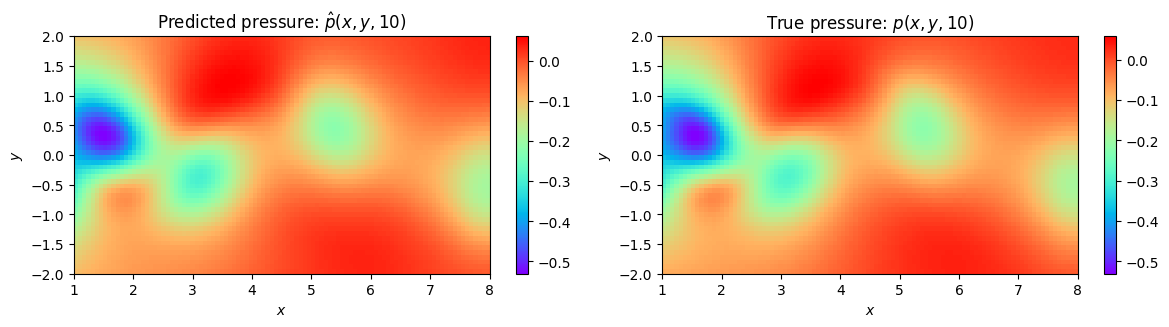

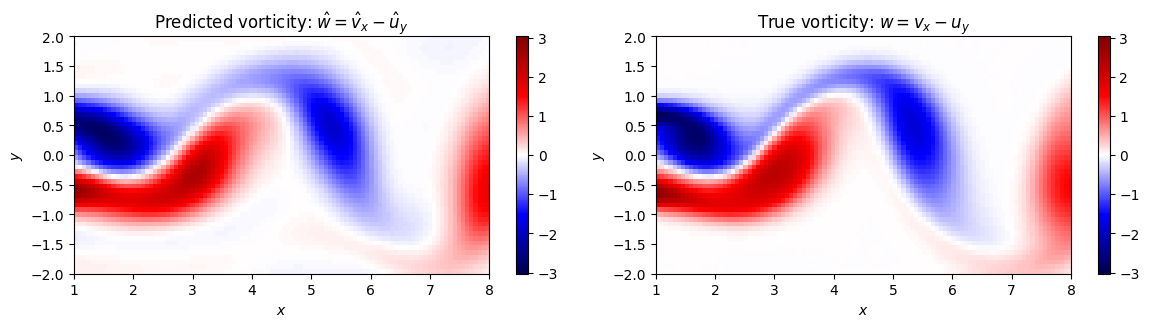

In [482]:
plot_data = data.get_quantities(model, t=10)

plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['p_pred'], extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted pressure: $\hat{p}(x, y, 10)$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['p_true'], extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True pressure: $p(x, y, 10)$')

plt.tight_layout()
# plt.savefig('gfx/ns-upinn-pressure_03.pdf', format='pdf', bbox_inches='tight')
plt.show()



plt.subplots(1, 2, figsize=(12, 3))

v = max(np.max(abs(plot_data['omega_pred'])), np.max(abs(plot_data['omega_true'])))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['omega_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted vorticity: $\hat{w} = \hat{v}_x - \hat{u}_y$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['omega_true'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True vorticity: $w = v_x - u_y$')

plt.tight_layout()
# plt.savefig('gfx/ns-upinn-inverse-vorticity.pdf', format='pdf', bbox_inches='tight')
plt.show()


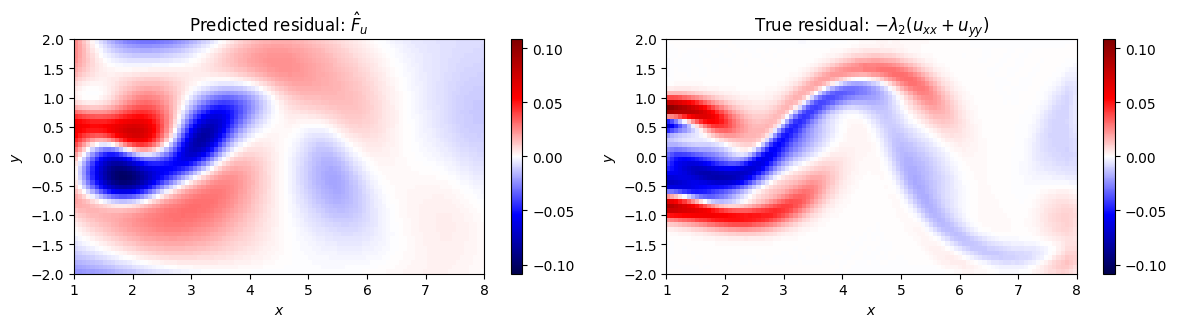

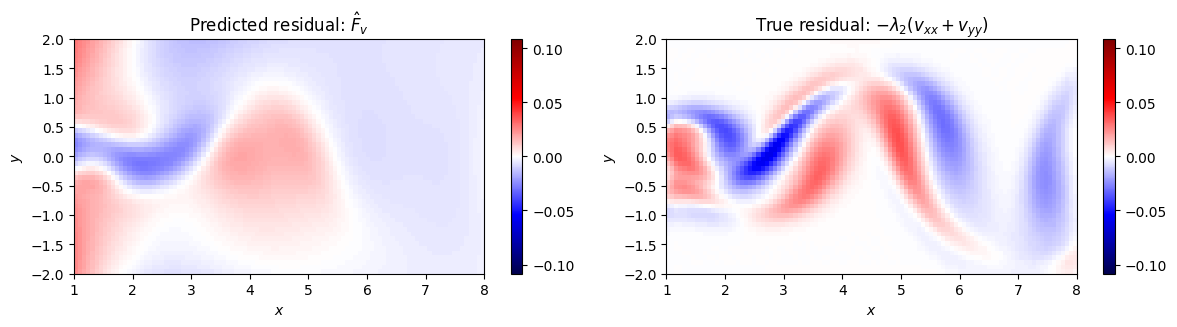

In [349]:
plt.subplots(1, 2, figsize=(12, 3))

v = max(np.max(abs(plot_data['f_res_pred'])), np.max(abs(plot_data['g_res_pred'])), np.max(abs(plot_data['f_res_true'])), np.max(abs(plot_data['g_res_true'])))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['f_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted residual: $\hat{F}_u$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['f_res_true'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True residual: $-\lambda_2 (u_{xx} + u_{yy})$')

plt.tight_layout()
# plt.savefig('gfx/ns-upinn-restrue_03.pdf', format='pdf', bbox_inches='tight')
plt.show()


plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)

plt.imshow(plot_data['g_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted residual: $\hat{F}_v$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['g_res_true'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True residual: $-\lambda_2 (v_{xx} + v_{yy})$')

plt.tight_layout()
# plt.savefig('gfx/ns-upinn-respred_03.pdf', format='pdf', bbox_inches='tight')
plt.show()


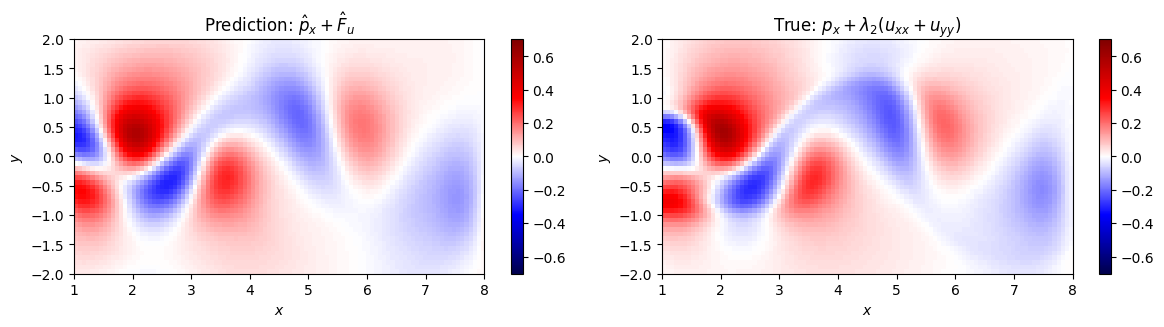

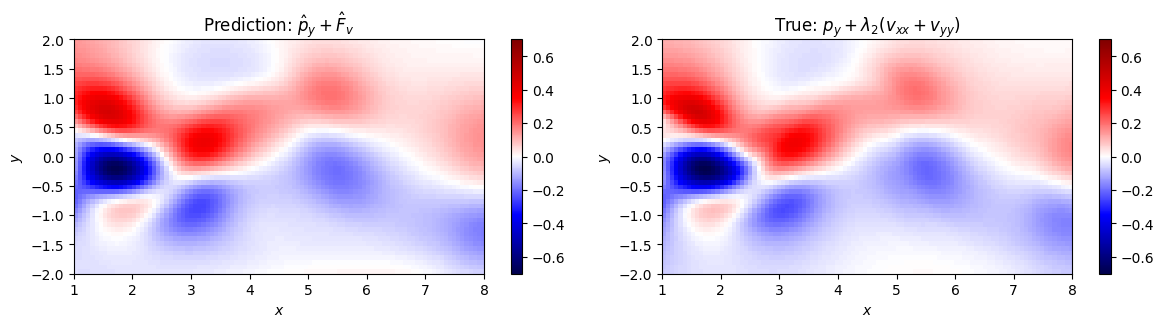

In [350]:
v = max(np.max(abs(plot_data['px_pred']+plot_data['f_res_pred'])), np.max(abs(plot_data['py_pred']+plot_data['g_res_pred'])), np.max(abs(plot_data['px_true']+plot_data['f_res_true'])), np.max(abs(plot_data['py_true']+plot_data['g_res_true'])))

plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)

plt.imshow(plot_data['px_pred'] + plot_data['f_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Prediction: $\hat{p}_x + \hat{F}_u$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['px_true'] + plot_data['f_res_true'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True: $p_x + \lambda_2 (u_{xx} + u_{yy})$')

plt.tight_layout()
# plt.savefig('gfx/ns-upinn-half-respred.pdf', format='pdf', bbox_inches='tight')
plt.show()


plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['py_pred'] + plot_data['g_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Prediction: $\hat{p}_y + \hat{F}_v$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['py_true'] + plot_data['g_res_true'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True: $p_y + \lambda_2 (v_{xx} + v_{yy})$')

plt.tight_layout()
# plt.savefig('gfx/ns-upinn-half-restrue.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [351]:
f_res_mse = 0
g_res_mse = 0

for t in data.Zd_full[:, 2].unique().numpy():
    temp = data.get_quantities(model, t=t)
    f_res_mse += np.mean((plot_data['px_pred'] + plot_data['f_res_pred'] - plot_data['px_true'] - plot_data['f_res_true'])**2)
    g_res_mse += np.mean((plot_data['py_pred'] + plot_data['g_res_pred'] - plot_data['py_true'] - plot_data['g_res_true'])**2)

f_res_mse /= len(data.Zd_full[:, 2].unique().numpy())
g_res_mse /= len(data.Zd_full[:, 2].unique().numpy())

print('f_res_mse:', f_res_mse)
print('g_res_mse:', g_res_mse)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.